![banner](https://github.com/priyammaz/PyTorch-Adventures/blob/main/src/visuals/rl_banner.png?raw=true)

# Deep Q-Learning

Finally we are at Neural Networks! I hope you have already take a look at the following notebooks as it sets the stage for everything we are about to do! Everything here is non-Deep Learning based RL methods. What we do is explore different methods to solve an RL environment.


1) [Policy Iteration](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Intro%20to%20Reinforcement%20Learning/Model-Based%20Learning/intro_rl_and_policy_iter.ipynb)
2) [Value Iteration](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Intro%20to%20Reinforcement%20Learning/Model-Based%20Learning/value_iteration.ipynb)
3) [Monte Carlo Learning](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Intro%20to%20Reinforcement%20Learning/Model-Free%20Learning/monte_carlo.ipynb)
4) [SARSA](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Intro%20to%20Reinforcement%20Learning/Model-Free%20Learning/sarsa.ipynb)
5) [Q-Learning](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Intro%20to%20Reinforcement%20Learning/Model-Free%20Learning/q_learning.ipynb)

There are also a few terms you should be familiar with:

1) Model vs Model Free Learning
    - Do you have the environments MDP or not?
2) On vs Off Policy
    - Do you update your policy based on the action you actually took or not?
  
## Recap Q-Learning

In Q-Learning (and other methods like SARSA) our goal is to learn the value of each action for every state in the system. The value again is your discounted returns, a sum of the reward I got now and the reward I can expect to get in the future. All methods under the branch of TD Learning can be written in this form:

$$Q(s,a) = Q(s,a) + \alpha_t(\text{TD Target} - Q(s,a))$$

- $Q(s,a)$ is our esimated value of taking an action at a state. We want to learn $Q$ such that we assign the highest value to the best action I could take in a state. But the key part here is that $Q(s,a)$ **IS AN ESTIMATE**. We want to continue improving this with real data collected from the environment
- **TD Target** is a calculation of the value of a specific action taken at a state, computed from real data (an experience). There are a few options for what we could use for our TD Target:
    - Monte Carlo: $G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ...$
    - SARSA: $r + \gamma * Q(s', a')$ -> Uses next action from the current policy (On Policy)
    - Q-Learning: $r + \gamma * max_{a'} Q(s', a')$ -> Uses max Q Value of next state (Off Policy)

So our **TD Target** is a calculation of our future rewards of an action at a state collected through an experience of interacting with the environment. The $Q(s,a)$ is our estimated value of an action at a state. Therefore, if we want to update our $Q(s,a)$, we can compute the difference between between our current estimate and our new calculation, scale it by some learning rate, and update our current estimate with that!

## Issue with Q-Learning 

Some of the main issus of Q-Learning in the real world comes down to two issues:
- **Number of State/Action pairs**
    - The FrozenLake problem we have been working with is just a 4x4 grid with 4 options to take at every state. This means we have a total possible 64 $Q(s,a)$ values to iterate and compute on (and that was basically our $Q$ table we constructed at the start of training). What if we have Millions of states? What if we have Millions of actions? This would not be computationally feasible to solve with just basic Q-Learning 
- **Continuous State/Actions**
    - We have also only been working on discrete states. You have to be in one of many states and you have to take one of many actions. What if your states are continuous or your actions are continuous? Think about an autonomous car. Its state is whatever the camera captured, there isnt some specific label like, oh you are in state 35 now.... Similarly, when making an action, its not just, take a right turn, its more like, turn the steering wheel 100 degrees to the right.
 
## Deep Q Learning

The $Q$ Table is just a discrete function that gives you what the value of an action is given a state. But anytime we have a function, cant we use our favorite Universal Function Approximator to approximate it instead? Yes! Instead of having some giant table, why not have a Neural Network take in the states and predict the value of your different actions that you can take!

Lets build up all the different parts of Deep Q Learning and you will see its not all that different from regular Q Learning!

### The Game

Just like before we need a game to play. Although FrozenLake has been fun, lets do something a bit more complicated!

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym
from IPython.display import Video

# !pip install swig
# !pip install gymnasium[box2d]
# !pip install gymnasium[other]

### Visualization

To visualize these games, we will use the ```gym.wrappers.RecordVideo``` which saves video of what happened, and then we can just show that video!

In [2]:
### Make the Game ###
env = gym.make("LunarLander-v3", render_mode="rgb_array")

### Recorder ####
env = gym.wrappers.RecordVideo(env, 
                               video_folder="./savevideos", 
                               disable_logger=True,
                               name_prefix="sample")

### Play Game ###
done = False
_ = env.reset(seed=42)
while not done:
    state, reward, done, _, _ = env.step(env.action_space.sample())
env.close()

### Visualize Game ###
Video("savevideos/sample-episode-0.mp4", embed=True)

/home/priyam/anaconda3/envs/torch/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /mnt/analysisdrive/analysis/NCSA_HAL_Tutorials/PyTorch for Reinforcement Learning/Intro to Deep Reinforcement Learning/Deep Q-Learning/savevideos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


The game looks pretty obvious. We have to:

- Get our lunar lander to fall between the flags
- Get it to fall gently so it doesn't crash!!

### States and Actions

Just like every environment, what are our states and actions here?

In [3]:
env = gym.make("LunarLander-v3", render_mode="rgb_array")
observation, _ = env.reset()

print(observation)

[ 0.00247087  1.4210094   0.25024837  0.44841233 -0.00285625 -0.05668507
  0.          0.        ]


Our state is a bunch of numbers! Well, first of all, if this is our State, defining a Q Table would be pretty challening as each state is defined by continuous values and not some discrete state. But what do these numbers mean? Here they are in order:

- X Coordinate of the Lander
- Y Coordinate of the Lander
- Velocity in X Direction
- Velocity in Y Direction
- Angle
- Angular Velocity
- Is the Left Leg Touching the Ground
- Is the Right Leg Touching the Ground

All of these numbers defines the current state of the lander. Our goal is to land it gently beteween the flags. So what are the possible actions?


In [4]:
env.action_space

Discrete(4)

We have 4 possible actions that we can pick from:

- 0: Do Nothing
- 1: Fire Left Engine
- 2: Fire Main Engine
- 3: Fire Right Engine

### Rewards

Our entire problem here depends on the rewards provided by the environment! Here is the built-in rewards provided by the game documentation:

For each step, the reward:

- is increased/decreased the closer/further the lander is to the landing pad.
- is increased/decreased the slower/faster the lander is moving.
- is decreased the more the lander is tilted (angle not horizontal).
- is increased by 10 points for each leg that is in contact with the ground.
- is decreased by 0.03 points each frame a side engine is firing.
- is decreased by 0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.
An episode is considered a solution if it scores at least 200 points.

### Replacing our Q Table with a Neual Network

Lets start with the first step then! The entire purpose is to paramaterize our Q Table via a Neural Network. In this case the network seems pretty simple! The input is our 8 numbers representing our state, and it must output 4 things at the end to select one of our four actions! And just like all Neural Networks, we will include some non-linearity in it as well!

In [5]:
class DQN(nn.Module):
    def __init__(self,
                 input_state_features=8, 
                 num_actions=4,
                 hidden_features=128):
        
        super(DQN, self).__init__()

        ### Lets just make 3 Linear Layers ###
        self.fc1 = nn.Linear(input_state_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features,hidden_features)
        self.fc3 = nn.Linear(hidden_features, num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

### Training in Batches (Replay Buffer)

In our Q-Learning training, we updated our table every step we took in the environment. This was fine for Q-Learning because we were using bootstrapping, but we have a neural network now. This means we need to train on batches. 

This leads to the Replay Buffer! It is basically a container that stored experiences. What we can do is play the game a bunch and store all of our experiences inside it. Then when we want to train the Neural Network, we can randomly sample experiences from it!

This replay buffer has to be able to do two things:

1. Have a maximum capacity. We only need to store so many memories, so we can cap our maximum number
2. We would expect our neural network to get better at playing the game as it trains. This means older memories where the network was struggling can be swapped out for newer ones, so the network can keep improving!


In [6]:
class TimeCapsule:

    """
    Simple Class to store and replace memories
    """
    
    def __init__(self, max_memories, num_state_features=8):

        self.max_memories = max_memories
        self.current_memories_counter = 0

        ### Current/Next State -> Each is a 8 length vector and we want to store max_memories ###
        self.state_memory = torch.zeros((self.max_memories, num_state_features), dtype=torch.float32)
        self.next_state_memory = torch.zeros((self.max_memories, num_state_features), dtype=torch.float32)

        ### Store the action take (just a single discrete number) ###
        self.action_memory = torch.zeros((self.max_memories, ), dtype=torch.long)

        ### Store the Reward (just a single number) ###
        self.reward_memory = torch.zeros((self.max_memories, ), dtype=torch.float32)

        ### Store if game ended (terminal state as boolean) ###
        self.terminal_memory = torch.zeros((self.max_memories, ), dtype=torch.bool)

    def add_memory(self, state, next_state, action, reward, terminal):

        ### Our containers have max_memories spot in it ###
        ### Once we fill up upto the max, then we want to ###
        ### start from the beginning again (replacing the oldest ###
        ### memories with the newest ones! ###
        ### We can do this with a modulo operation easily ###

        idx = self.current_memories_counter % self.max_memories

        ### Lets Store All our Memories At Those Indexes ###
        self.state_memory[idx] = torch.tensor(state, dtype=self.state_memory.dtype)
        self.next_state_memory[idx] = torch.tensor(next_state, dtype=self.next_state_memory.dtype)
        self.action_memory[idx] = torch.tensor(action, dtype=self.action_memory.dtype)
        self.reward_memory[idx] = torch.tensor(reward, dtype=self.reward_memory.dtype)
        self.terminal_memory[idx] = torch.tensor(terminal, dtype=self.terminal_memory.dtype)
        
        ### Iterate Memory Counter ###
        self.current_memories_counter += 1

    def access_memories(self, batch_size, device="cpu"):

        ### How many memories do we have? ###
        ### either we havent filled our capsule ###
        ### and we have current_memories_counter or ###
        ### we have filled it so our number of memories is ###
        ### just the size of our capsule ###
        
        total_memories = min(self.current_memories_counter, self.max_memories) 

        if total_memories < batch_size:
            return None

        ### Sample Random Indexes from our total memories ###
        rand_sample_idx = np.random.choice(np.arange(total_memories), size=batch_size, replace=False)
        rand_sample_idx = torch.tensor(rand_sample_idx, dtype=torch.long)
        
        ### Sample those indexes and return ###
        batch = {"states": self.state_memory[rand_sample_idx].to(device),
                 "next_states": self.next_state_memory[rand_sample_idx].to(device),
                 "actions": self.action_memory[rand_sample_idx].to(device),
                 "rewards": self.reward_memory[rand_sample_idx].to(device),
                 "terminal": self.terminal_memory[rand_sample_idx].to(device)}

        return batch
        
        
        

### Build Our Agent

Now its time to build our Agent! This agent needs to be able to do a few things:

- Store Memories (our ```TimeCapsule``` from earlier)
- Take an Epsilon-Greedy Action (with a schedule so initially we are in exploration mode and later we are taking the best actions)
- Update the Neural Network with its cached experiences

#### What is our Loss?

Remember this:

$$Q(s,a) = Q(s,a) + \alpha_t(\text{TD Target} - Q(s,a))$$

Where our **TD Target** is:

$$r + \gamma * max_{a'} Q(s', a')$$

This entire function is doing one thing, updating our $Q$ table in the direction of the **TD Target**. If our **TD Target** is greater than $Q(s,a)$ then we will increase our updated $Q(s,q)$ and vise-versa. So really, our goal is to make sure our $Q(s,a)$ is correctly predicting our **TD Target**, which makes sense, we want our $Q$ table to be a good esimate of the future discounted rewards I expect to get. 

So if our goal is just to get $Q(s,a)$ close to the **TD Target**, then with our Neural Network, why not just compute the **L1** loss between our current prediction that comes from the model and the cooresponding target that we can compute from data?

That is exactly what we will do! We could use ```L1```, ```MSE```, ```Huber```, or any other loss like this and it would (probably) still work!

In [7]:
class Agent:
    def __init__(self,
                 max_memories=100_000,
                 discount_factor=0.99, 
                 learning_rate=0.001,
                 input_state_features=8, 
                 num_actions=4,
                 hidden_features=128,
                 epsilon=1.0, 
                 epsilon_decay=0.999, 
                 min_epsilon=0.05,
                 device="cpu"):

        self.max_memories = max_memories
        self.discount_factor = discount_factor 
        self.learning_rate = learning_rate
        self.input_state_features = input_state_features
        self.num_actions = num_actions
        self.action_space = np.arange(self.num_actions)
        self.hidden_features = hidden_features
        self.epsilon = epsilon 
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon 
        self.device = device
        
        ### Set the Model ###
        self.DQN = DQN(self.input_state_features, self.num_actions, self.hidden_features).to(device)

        ### Set the Optimizer ###
        self.optimizer = optim.Adam(self.DQN.parameters(), lr=self.learning_rate)

        ### Set the Loss Function ###
        self.loss_fn = nn.MSELoss()

        ### Load our TimeCapsule ###
        self.timecapsule = TimeCapsule(self.max_memories, self.input_state_features)

    def select_action(self, state):

        ### Sanity Check: Make Sure its a Tensor ###
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, device=self.device)

        ### Sanity Check: Make sure there is a batch dimension ###
        if state.dim() == 1:
            state = state.unsqueeze(0)

        ### Sanity Check: Make sure input features is the same as our neural network ###
        assert state.shape[-1] == self.input_state_features, f"Passing {state.shape[-1]} features, expect {self.input_state_features}"
        
        ### Epsilon Greedy Selection ###
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            self.DQN.eval()
            with torch.no_grad():
                Q_s_a = self.DQN(state)
            action = torch.argmax(Q_s_a).item()
            self.DQN.train()

        return action

    def update_epsilon(self):
        ### Update Epsilon with an exponential decay scheduler (with lower limit) ###
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

    def inference(self, state, device="cpu"):

        ### Quick Inference Script to Get Action from State ###
        self.DQN = self.DQN.to(device)
        self.DQN.eval()
        
        with torch.no_grad():
            Q_s_a = self.DQN(state.to(device))
            
        return torch.argmax(Q_s_a).item()
        
    def train_step(self, batch_size):

        ### Grab samples from our capsule and train!! ###
        batch = self.timecapsule.access_memories(batch_size, self.device)

        ### If we didnt have enough samples ###
        if batch is None:
            return None

        ### Get our Estimated Q Values for the Current States ###
        ### [B x Actions]
        q_estimate = self.DQN(batch["states"])

        ### Get the Estimates for the Specific Action that was taken ###
        ### [B]
        q_estimate = torch.gather(q_estimate, index=batch["actions"].unsqueeze(-1), dim=-1).squeeze(-1) 

        ### Get our TD Target (for the next state) ###
        ### reward + gamma * max_{a'} Q(next_state, a')
        
        ### Step 1: get our Q for the next state ###
        ### Also, we are using our model here (inferencing) ###
        ### So need to compute gradients! ###
        with torch.no_grad():
            ### [B x Actions]
            self.DQN.eval()
            q_next_estimate = self.DQN(batch["next_states"])
            self.DQN.train()

        ### Step 2: Get our max next state action Q value (off policy) ###
        ### We could also sample an action (using epsilon greedy) ###
        ### and use that action, but then its SARSA on-policy ###
        ### [B]
        max_q_next_estimate = torch.max(q_next_estimate, dim=-1).values

        ### Step 3: Compute Our formula! If we are in a terminal state, then there is no future ###
        ### reward as the game is over! So lets go ahead and zero out the ###
        ### Future losses for terminal states and make them just the ### 
        ### reward only (batch["terminal"] is a boolean vector of True if terminal) ###
        td_target = batch["rewards"] + self.discount_factor * max_q_next_estimate * (~batch["terminal"])

        ### Step 4: We want to move our model outputs (q_estimate) close to the TD Targets ###
        loss = self.loss_fn(td_target, q_estimate)

        ### Update Model! ###
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

        ### Update Epsilon (Exploration vs Exploitaion) ###
        self.update_epsilon()

## Lets Train a Model!!

Time to train our Agent! This is pretty straight forward now. We want to play for a bunch of games till completion, storing the states we find ourselves in as we go to sample from! One thing we add is a ending condition. The game docs say that a final score of above 200 means a successful game. Therefore we can set a tolerance, so that once we beat that score consistently, then we can stop training!

In [8]:
def trainer(env, 
            num_games=500,
            min_reward=200, 
            game_tolerance=10,
            max_memories=100_000,
            discount_factor=0.99, 
            learning_rate=0.001,
            batch_size=64,
            input_state_features=8, 
            num_actions=4,
            hidden_features=128,
            epsilon=1.0, 
            epsilon_decay=0.999, 
            min_epsilon=0.05,
            log_freq=5, 
            running_avg_steps=25,
            device="cpu"):

    ### Define our Agent ###
    agent = Agent(max_memories=max_memories,
                  discount_factor=discount_factor, 
                  learning_rate=learning_rate,
                  input_state_features=input_state_features, 
                  num_actions=num_actions,
                  hidden_features=hidden_features,
                  epsilon=epsilon, 
                  epsilon_decay=epsilon_decay, 
                  min_epsilon=min_epsilon,
                  device=device)

    ### Tolerance ### 
    ending_tol = 0
    
    ### Store our Final Game Scores ###
    log = {"scores": [], 
           "running_avg_scores": []}

    ### Training Loop ###
    for i in range(num_games):

        ### Current Game Score ###
        score = 0

        ### Start the Game ###
        state, _ = env.reset()
        done = False

        while not done:

            ### Epsilon Greedy Selection ###
            action = agent.select_action(state)

            ### Interact with Environment ###
            next_state, reward, terminal, truncated, _= env.step(action)
            done = terminal or truncated

            ### Add our current reward to the reward ###
            score += reward

            ### Store this experience in our time capsule! ###
            agent.timecapsule.add_memory(state, next_state, action, reward, done)

            ### Lets Learn Something! Will only work once we have enough samples in our cache ###
            agent.train_step(batch_size)

            ### Set the State as the Next State ###
            state = next_state

        ### Store the Score ###
        log["scores"].append(score)
        running_avg_score = np.mean(log["scores"][-running_avg_steps:])
        log["running_avg_scores"].append(running_avg_score)

        ### Print Results of this Game ###
        if i % log_freq == 0:
            print(f"Game #: {i} | Score: {score} | Moving Avg Scores: {running_avg_score} | Epsilon: {agent.epsilon}")
        
        ### If our Score more than the min then iterate our ending condition ###
        if score >= min_reward:
            ending_tol += 1

            if ending_tol == game_tolerance:
                break
        else:
            ending_tol = 0

    print("Completed Training")

    return agent, log
            
device = "cuda" if torch.cuda.is_available() else "cpu"
agent, log = trainer(env, device=device)    


Game #: 0 | Score: -272.3729409013274 | Moving Avg Scores: -272.3729409013274 | Epsilon: 0.9811700348643991
Game #: 5 | Score: -409.2324621573677 | Moving Avg Scores: -280.04379110793144 | Epsilon: 0.49690832175285177
Game #: 10 | Score: -108.57638068461198 | Moving Avg Scores: -198.38672101932477 | Epsilon: 0.07697440192173557
Game #: 15 | Score: -40.70732842420595 | Moving Avg Scores: -158.09779534584612 | Epsilon: 0.05
Game #: 20 | Score: -60.23146931347791 | Moving Avg Scores: -136.8444681670631 | Epsilon: 0.05
Game #: 25 | Score: -39.95957200608283 | Moving Avg Scores: -111.80559874097716 | Epsilon: 0.05
Game #: 30 | Score: -62.36943104465859 | Moving Avg Scores: -61.908304691791244 | Epsilon: 0.05
Game #: 35 | Score: -31.936069366922197 | Moving Avg Scores: -45.52524512364205 | Epsilon: 0.05
Game #: 40 | Score: -113.45367375114047 | Moving Avg Scores: -39.83208102509192 | Epsilon: 0.05
Game #: 45 | Score: -75.05696972148417 | Moving Avg Scores: -38.45895078897496 | Epsilon: 0.05


### Lets Plot a Game!

In [9]:
def record_game(env, agent, prefix, device="cuda"):

    env = gym.wrappers.RecordVideo(env, 
                                   video_folder="./savevideos", 
                                   video_length=0, 
                                   disable_logger=True,
                                   name_prefix=prefix)

    done = False
    state, _ = env.reset(seed=42)
    
    while not done:

        ### Get Predicted Action ###
        action = agent.inference(torch.tensor(state).unsqueeze(0))

        ### Step in Environment ###
        new_state, reward, terminal, truncate, _ = env.step(action)
        done = terminal or truncate 
        
        ### State is our New State ###
        state = new_state
        
    env.close()

record_game(env, agent, prefix="q_learning_unstable")

Video("savevideos/q_learning_unstable-episode-0.mp4", embed=True)

/home/priyam/anaconda3/envs/torch/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /mnt/analysisdrive/analysis/NCSA_HAL_Tutorials/PyTorch for Reinforcement Learning/Intro to Deep Reinforcement Learning/Deep Q-Learning/savevideos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


### Lets Take A Look At our Scores!

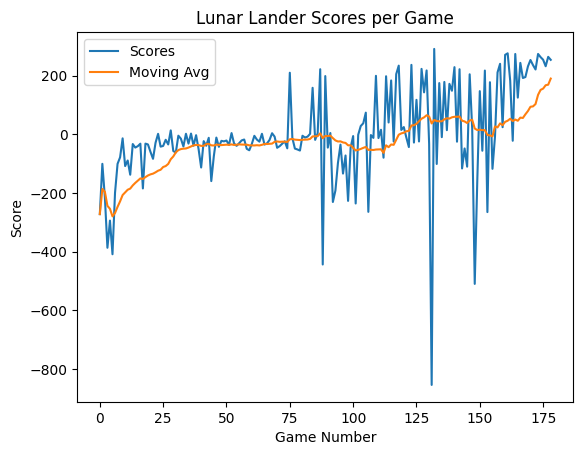

In [10]:
plt.plot(log["scores"], label="Scores")
plt.plot(log["running_avg_scores"], label="Moving Avg")
plt.title("Lunar Lander Scores per Game")
plt.xlabel("Game Number")
plt.ylabel("Score")
plt.legend()
plt.show()

### Moving Target Problem

It looks like we solved our Environment here, but do you notice those giant oscillations in our scores? This is due to a common problem for standard Q-Learning, and that is these oscilations due to a moving target. Lets remind ourselves what we are doing.

We are using our $Q$ Network to do both:

1) Calculate our $Q$ Estimate for the current state/action pair
2) Compute our TD Target by using the estimate of the $Q$ model for the next states/action pair

Our loss function then tries to minimize the distance between the our $Q$ estimate and the TD Target! But do you see the problem here, because the same model is being used for both, by the time we have updated our $Q$ model, the TD Target has already changed! So we are chasing down this TD Target, but because it continues to change as we train, it will lead to noisy, unstable training. 

The fix is very simple, when we compute our TD Target, hold that target for a few iterations before updating again. If our TD Target stays the same for a few iterations, it allows the model a change to learn that specific TD Target, before we update it again. To do this is very simple:

Create an exact copy of the $Q$ model, that acts as your target, called $Q_{target}$. This $Q_{target}$ will be used as our estimate for the $\max$ to calculate our TD Target. This second model **IS STATIC**. It is not trained, only used in evaluation mode. You can imagine that $Q_{target}$ is just an older version of our current $Q$ model. Once we have trained a few iterations, we can update our $Q_{target}$ with our updated $Q$ again. 

Again, the entire point of this is so our TD Target isn't always moving around and gives the Neural Network an opportunity to minimize a non-moving target! Another way to think about it is, lets say you are trying to catch a fish with your bare hands. By the time you grab in the water where the fish was, it has already moved on. The implementation we have done so far basically has the same problem

### Update the Agent

All we need to do is add a copy of the model, and add the method to copy the weights of our $Q$ model into our $Q_{target}$. Then in our training step, we will use this $Q_{target}$ for our estimation of future steps

In [11]:
class Agent:
    def __init__(self,
                 max_memories=100_000,
                 discount_factor=0.99, 
                 learning_rate=0.001,
                 input_state_features=8, 
                 num_actions=4,
                 hidden_features=128,
                 epsilon=1.0, 
                 epsilon_decay=0.001, 
                 min_epsilon=0.05,
                 device="cpu"):

        self.max_memories = max_memories
        self.discount_factor = discount_factor 
        self.learning_rate = learning_rate
        self.input_state_features = input_state_features
        self.num_actions = num_actions
        self.action_space = np.arange(self.num_actions)
        self.hidden_features = hidden_features
        self.epsilon = epsilon 
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon 
        self.device = device
        
        self.DQN = DQN(self.input_state_features, self.num_actions, self.hidden_features).to(device)

        ################
        ### NEW CODE ###
        self.DQN_NEXT = DQN(self.input_state_features, self.num_actions, self.hidden_features).to(device)
        self.DQN_NEXT.load_state_dict(self.DQN.state_dict())
        self.DQN_NEXT.eval()
        ################
        
        self.optimizer = optim.Adam(self.DQN.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.MSELoss()
        self.timecapsule = TimeCapsule(self.max_memories, self.input_state_features)

    def select_action(self, state):


        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, device=self.device)
            
        if state.dim() == 1:
            state = state.unsqueeze(0)
            
        assert state.shape[-1] == self.input_state_features, f"Passing {state.shape[-1]} features, expect {self.input_state_features}"
        
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            self.DQN.eval()
            with torch.no_grad():
                Q_s_a = self.DQN(state)
            action = torch.argmax(Q_s_a).item()
            self.DQN.train()

        return action

    def update_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

    def inference(self, state, device="cpu"):

        ### Quick Inference Script to Get Action from State ###
        self.DQN = self.DQN.to(device)
        self.DQN.eval()
        
        with torch.no_grad():
            Q_s_a = self.DQN(state.to(device))
            
        return torch.argmax(Q_s_a).item()
        
    def update_target_network(self):
        ####################################################
        ### NEW CODE TO UPDATE NEXT WITH TRAINED WEIGHTS ###
        self.DQN_NEXT.load_state_dict(self.DQN.state_dict())
        ####################################################

    def train_step(self, batch_size):

        batch = self.timecapsule.access_memories(batch_size, self.device)
        
        if batch is None:
            return None

        self.DQN.train()
        q_estimate = self.DQN(batch["states"])
        q_estimate = torch.gather(q_estimate, index=batch["actions"].unsqueeze(-1), dim=-1).squeeze(-1) 

        with torch.no_grad():

            #############################################################
            ### NEW CODE TO GET NEXT STATE Q VALUES FROM OUR DQN_NEXT ###
            q_next_estimate = self.DQN_NEXT(batch["next_states"])
            #############################################################

        max_q_next_estimate = torch.max(q_next_estimate, dim=-1).values
        td_target = batch["rewards"] + self.discount_factor * max_q_next_estimate * (~batch["terminal"])
        loss = self.loss_fn(td_target, q_estimate)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.DQN.parameters(), max_norm=1.0)
        self.optimizer.step()
        self.update_epsilon()

### Update the Trainer

Similarly, the trainer needs to be updated so we are updating our $Q$ model with our lagged $Q_{target}$ every few iterations! This way we update our targets so the model can continue to learn as it improves.

In [15]:
def trainer(env, 
            num_games=500,
            update_target_freq=3,
            min_reward=200, 
            game_tolerance=10,
            max_memories=100_000,
            discount_factor=0.99, 
            learning_rate=0.001,
            batch_size=64,
            input_state_features=8, 
            num_actions=4,
            hidden_features=128,
            epsilon=1.0, 
            epsilon_decay=0.999, 
            min_epsilon=0.05,
            log_freq=5, 
            running_avg_steps=25,
            device="cpu"):

    ### Define our Agent ###
    agent = Agent(max_memories=max_memories,
                  discount_factor=discount_factor, 
                  learning_rate=learning_rate,
                  input_state_features=input_state_features, 
                  num_actions=num_actions,
                  hidden_features=hidden_features,
                  epsilon=epsilon, 
                  epsilon_decay=epsilon_decay, 
                  min_epsilon=min_epsilon,
                  device=device)

    ### Tolerance ### 
    ending_tol = 0
    
    ### Store our Final Game Scores ###
    log = {"scores": [], 
           "running_avg_scores": []}

    ### Training Loop ###
    for i in range(num_games):

        ### Current Game Score ###
        score = 0

        ### Step Counter ###
        step = 0

        ### Start the Game ###
        state, _ = env.reset()
        done = False

        while not done:

            ### Epsilon Greedy Selection ###
            action = agent.select_action(state)

            ### Interact with Environment ###
            next_state, reward, terminal, truncated, _= env.step(action)
            done = terminal or truncated

            ### Add our current reward to the reward ###
            score += reward

            ### Store this experience in our time capsule! ###
            agent.timecapsule.add_memory(state, next_state, action, reward, done)

            ### Lets Learn Something! Will only work once we have enough samples in our cache ###
            agent.train_step(batch_size)

            ### Update DQN_NEXT every update_target_freq Iterations ###
            if step % update_target_freq == 0:
                agent.update_target_network()

            ### Iterate Step ###
            step += 1
            
            ### Our State is now the Next State ###
            state = next_state


        ### Store the Score ###
        log["scores"].append(score)
        running_avg_score = np.mean(log["scores"][-running_avg_steps:])
        log["running_avg_scores"].append(running_avg_score)
        

        ### Print Results of this Game ###
        if i % log_freq == 0:
            print(f"Game #: {i} | Score: {score} | Moving Avg Scores: {running_avg_score} | Epsilon: {agent.epsilon}")
        
        ### If our Score more than the min then iterate our ending condition ###
        if score >= min_reward:
            ending_tol += 1

            if ending_tol == game_tolerance:
                break
        else:
            ending_tol = 0
            
    print("Completed Training")
    return agent, log
            
device = "cuda" if torch.cuda.is_available() else "cpu"
agent, log = trainer(env, device=device)

Game #: 0 | Score: -143.7011951129905 | Moving Avg Scores: -143.7011951129905 | Epsilon: 0.9502544225688344
Game #: 5 | Score: -232.64801862086009 | Moving Avg Scores: -149.48845732283772 | Epsilon: 0.5602962074911925
Game #: 10 | Score: -85.0030665604998 | Moving Avg Scores: -153.208738880402 | Epsilon: 0.31424608621522926
Game #: 15 | Score: -75.67440855306789 | Moving Avg Scores: -149.8037127911321 | Epsilon: 0.11157070860138803
Game #: 20 | Score: -72.11196360640103 | Moving Avg Scores: -144.4146713330359 | Epsilon: 0.05
Game #: 25 | Score: -30.65437414856372 | Moving Avg Scores: -122.74098123498239 | Epsilon: 0.05
Game #: 30 | Score: -113.60112741691678 | Moving Avg Scores: -100.73696127433422 | Epsilon: 0.05
Game #: 35 | Score: 98.7535884143047 | Moving Avg Scores: -63.19802933310777 | Epsilon: 0.05
Game #: 40 | Score: 198.85537989860654 | Moving Avg Scores: -0.5314465833097438 | Epsilon: 0.05
Game #: 45 | Score: 138.48317059865678 | Moving Avg Scores: 62.91923761977894 | Epsilon

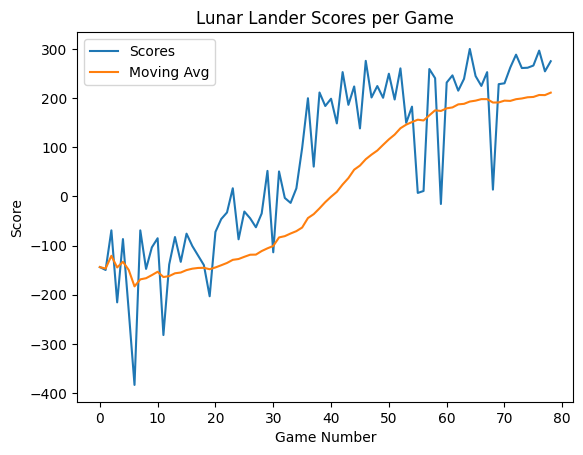

In [17]:
plt.plot(log["scores"], label="Scores")
plt.plot(log["running_avg_scores"], label="Moving Avg")
plt.title("Lunar Lander Scores per Game")
plt.xlabel("Game Number")
plt.ylabel("Score")
plt.legend()
plt.show()

As we can see our model trained faster (less iterations needed) and our reward curve is much less noisy!

In [22]:
record_game(env, agent, prefix="q_learning_stable")

Video("savevideos/q_learning_stable-episode-0.mp4", embed=True)

### Thats it!

We have successfully implemented our first Deep RL model! But there are still a lot of places to improve on this. The main issue is the Overestimation problem of: 
$$\max_{a'}Q(s',a')$$

Because we are using the same network (the $Q$ model and its delayed copy $Q_{target}$), the $\max$ operation often will overestimate the true value. This can't be helped as our estimate is actively being trained, therefore is a noisy estimate of the true value. We are then grabbing the $\max$ from this noise, and this will lead to having a value that tends to be higher than what it should be. 

To fix this, we will move onto ```Double Deep Q Networks``` next time!